### Thickness budget in temperature space

In [1]:
%load_ext autoreload
%autoreload 2

In [41]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import budgetcalcs as bc
import calc_wmt as wmt
import datetime
import cftime

In [42]:
rootdir = '/archive/gam/MOM6-examples/ice_ocean_SIS2/Baltic_OM4_025_15d/'
filename = '19000101.ocean_daily.nc'
filename_snap = '19000101.ocean_daily_snap.nc'
filename_grid = '19000101.ocean_static.nc'
ds = xr.open_dataset(rootdir+filename)
ds_snap = xr.open_dataset(rootdir+filename_snap)
grid = xr.open_dataset(rootdir+filename_grid)

cp = 3992
rho0 = 1035

In [43]:
# Load initial conditions, snapshop
filename_ic = 'MOM_IC.nc'
ds_ic = xr.open_dataset(rootdir+filename_ic)
terms = ['Temp','Salt','h']
ds_ic
ds_ic = ds_ic[terms].rename({'Temp':'temp','Salt':'salt','h':'thkcello',
                            'Time':'time','Layer':'zl','lath':'yh','lonh':'xh'}).squeeze()
time_new = cftime.DatetimeNoLeap(1900,1,1)
ds_ic = ds_ic.assign_coords({'time':time_new})
ds_snap = xr.concat([ds_ic,ds_snap],dim='time')

In [44]:
# Budget terms
heat_terms = ['opottemptend','T_advection_xy','Th_tendency_vert_remap',
              'boundary_forcing_heat_tendency','internal_heat_heat_tendency',
              'opottempdiff','opottemppmdiff','frazil_heat_tendency']
salt_terms = ['osalttend','S_advection_xy','Sh_tendency_vert_remap',
              'boundary_forcing_salt_tendency','osaltdiff','osaltpmdiff']
h_terms = ['dhdt','dynamics_h_tendency','vert_remap_h_tendency',
           'boundary_forcing_h_tendency','internal_heat_h_tendency']

In [45]:
# Calculate material derivative and diffusive terms
# HEAT
signsLHS = [-1,1,1]
signsRHS = [1,1,1,1,1]
termsLHS = heat_terms[:3]
termsRHS = heat_terms[3:]
Dheat, dheat, error_heat = bc.calc_materialderivative(ds,termsLHS,signsLHS,termsRHS,signsRHS,plot=False)

In [53]:
def calc_refine(da,refineby,variable_type,vertc='zl'):
    nk = len(da[vertc])
    # Set vertical coordinate to layer index
    da=da.assign_coords({vertc:np.linspace(1,nk,nk)})
    # Assign a k-value for the interfaces
    k_i = np.linspace(0.5,nk+0.5,nk+1)
    # Develop the super grid, based on the interfaces
    k_i_target = np.linspace(0.5,nk+0.5,nk*refineby+1)
    # Get the value of the layers on the super grid
    k_l_target = 0.5*(k_i_target[1:]+k_i_target[:-1])
    
    # Refine the grid
    if variable_type == 'intensive':
        da_refined = da.interp({vertc:k_l_target},method='linear',kwargs={'fill_value':'extrapolate'})
    if variable_type == 'extensive':
        da_refined = xr.zeros_like(da.interp({vertc:k_l_target}))
        for k in range(nk):
            index = np.arange(k*refineby,(k+1)*refineby)
            vertc_ones = xr.DataArray(np.ones(shape=(refineby)),dims=[vertc],coords={vertc:k_l_target[index]})
            chunk = (da.isel({vertc:k})/refineby)*vertc_ones
            # Input array must have same dimensional order as indexed array
            ### THERE MUST BE A MORE EFFICIENT WAY TO DO THIS ###
            if len(da.dims)==1:
                da_refined.loc[{vertc:k_l_target[index]}]=chunk
            elif len(da.dims)==2:
                da_refined.loc[{vertc:k_l_target[index]}]=chunk.transpose(list(da.dims)[0],list(da.dims)[1])
            elif len(da.dims)==3:
                da_refined.loc[{vertc:k_l_target[index]}]=chunk.transpose(list(da.dims)[0],list(da.dims)[1],list(da.dims)[2])
            elif len(da.dims)==4:
                da_refined.loc[{vertc:k_l_target[index]}]=chunk.transpose(list(da.dims)[0],list(da.dims)[1],list(da.dims)[2],list(da.dims)[3])
    return da_refined

In [79]:
# Time-mean : for evaluating dia-boundary transport and integrated process tendencies
l = ds['temp'] # Time-mean volume-defining tracer
l_name = l.name+'_bin' # Naming of binning variable as will be defined by xhistogram
dl = dheat/cp # Sum of diffusive tendencies for volume-defining tracer
c = xr.ones_like(ds['thkcello']) # Time-mean of budget tracer

# Snapshots: for evaluating budget tracer content tendency
# NOTE: time-mean i corresponds to the snapshots at i and i-1
# so, for example, diff(snap[1]-snap[0])/dt = mean[1]
l_snap = ds_snap['temp'] # Snapshots of volume-defining tracer
c_snap = xr.ones_like(ds_snap['thkcello']) # Snapshots of budget tracer
h_snap = ds_snap['thkcello'] # Snapshots of layer thickness (for tracer content calculation)

# Grid dimensions
area = grid.areacello # Grid dimensions

# Time-mean tendencies of budget tracer due to different processes
f_c = ds['boundary_forcing_h_tendency'] # Boundary forcing

refine = False
refineby = 64

In [80]:
# Refine vertical grid
if refine:
    l = calc_refine(l, refineby=refineby, variable_type='intensive')
    dl = calc_refine(dl, refineby=refineby, variable_type='extensive')
    c = calc_refine(c, refineby=refineby, variable_type='intensive')
    l_snap = calc_refine(l_snap, refineby=refineby, variable_type='intensive')
    c_snap = calc_refine(c_snap, refineby=refineby, variable_type='intensive')
    h_snap = calc_refine(h_snap, refineby=refineby, variable_type='extensive')

    f_c = calc_refine(f_c, refineby=refineby, variable_type='extensive')

In [81]:
# Binning variables
delta_l = 0.25
l_i_vals = np.arange(-4,36,delta_l)
t = 1

# Calculation of budget tracer content tendency, derived from snapshots
C = wmt.calc_P(rho0*c_snap*h_snap,l_snap,l_i_vals,area) # Binning at snapshots
dCdt = C.diff('time')/(C.time.diff('time').astype('float')*1E-9)
dCdt = dCdt.isel(time=t)
dCdt_alt = C.differentiate('time').isel(time=t) # Finite difference in time
dCdt = dCdt.rename({l_snap.name+'_bin':l_name}) # Rename dimension for consistency
dCdt_alt = dCdt_alt.rename({l_snap.name+'_bin':l_name})
# Calculation of E : budget tracer tendency due to dia-boundary mass transport 
E_c = wmt.calc_E(c,l,dl,l_i_vals,area,plot=False).isel(time=t)
# Calculation of P^n : volume integrated budget tracer tendencies
F_c = wmt.calc_P(rho0*f_c,l,l_i_vals,area).isel(time=t)

<xarray.DataArray ()>
array(2.15992816e+08)
Coordinates:
    time     object 1900-01-23 12:00:00


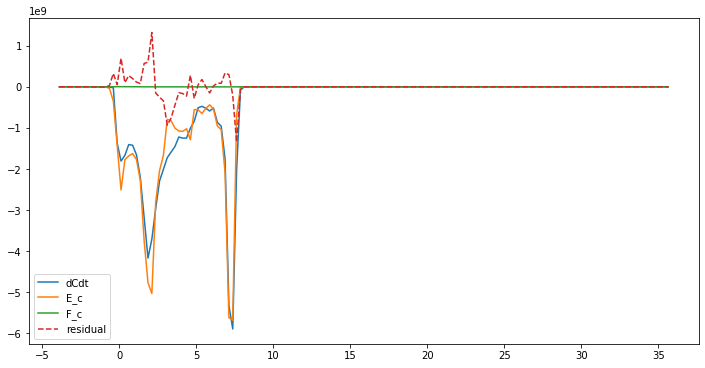

In [82]:
fig,ax1 = plt.subplots(figsize=(12,6),ncols=1)
ax1.plot(dCdt[l_name],dCdt,label='dCdt')
ax1.plot(E_c[l_name],E_c,label='E_c')
ax1.plot(F_c[l_name],F_c,label='F_c')
residual = dCdt-E_c-F_c
ax1.plot(residual[l_name],residual,linestyle='--',label='residual')
ax1.legend()
print(np.sqrt(np.mean(residual**2)))

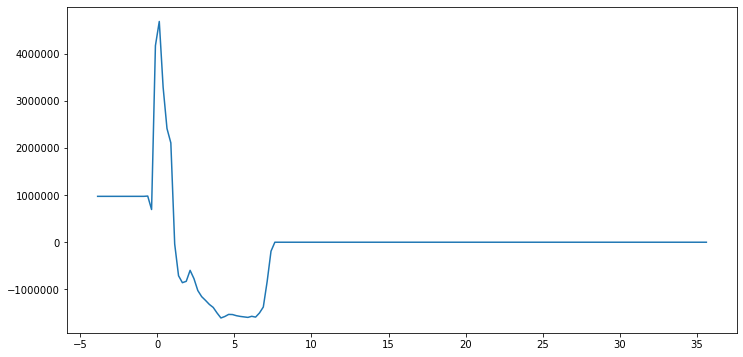

In [22]:
fig,ax1 = plt.subplots(figsize=(12,6),ncols=1)
ax1.plot(F_c[l_name],F_c,label='F_c')

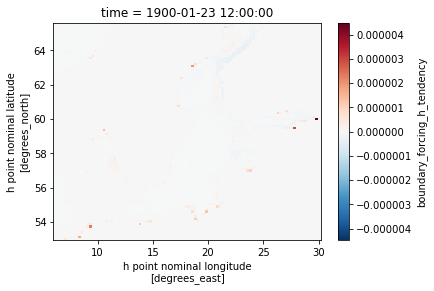

In [23]:
ds['boundary_forcing_h_tendency'].isel(time=1).sum('zl').plot()